# Volatility pattern

In [1]:
!python --version

Python 3.9.16


In [2]:
# Install dependencies
%pip install -q numerapi pandas lightgbm cloudpickle pyarrow scikit-learn scipy==1.10.1

Note: you may need to restart the kernel to use updated packages.


In [1]:
from numerapi import NumerAPI
import pandas as pd
import json
import cloudpickle
import matplotlib.pyplot as plt 
import numpy as np
napi = NumerAPI()

# use one of the latest data versions
DATA_VERSION = "v4.3"

In [2]:
napi.download_dataset("v4.3/train_int8.parquet", "../v4.3/train_int8.parquet")
napi.download_dataset("v4.3/validation_int8.parquet", "../v4.3/validation_int8.parquet")
napi.download_dataset("v4.3/live_int8.parquet", "../v4.3/live_int8.parquet")
napi.download_dataset("v4.3/live_example_preds.parquet", "../v4.3/live_example_preds.parquet")
napi.download_dataset("v4.3/validation_example_preds.parquet", "../v4.3/validation_example_preds.parquet")
napi.download_dataset("v4.3/features.json", "../v4.3/features.json")
napi.download_dataset("v4.3/meta_model.parquet", "../v4.3/meta_model.parquet")
napi.download_dataset("v4.3/live_benchmark_models.parquet", "../v4.3/live_benchmark_models.parquet")
napi.download_dataset("v4.3/validation_benchmark_models.parquet", "../v4.3/validation_benchmark_models.parquet")
napi.download_dataset("v4.3/train_benchmark_models.parquet", "../v4.3/train_benchmark_models.parquet")

2024-03-03 13:03:09,185 INFO numerapi.utils: target file already exists
2024-03-03 13:03:09,185 INFO numerapi.utils: download complete
2024-03-03 13:03:10,050 INFO numerapi.utils: target file already exists
2024-03-03 13:03:10,050 INFO numerapi.utils: starting download
../v4.3/validation_int8.parquet: 4.99GB [02:07, 39.2MB/s]                            
2024-03-03 13:05:18,124 INFO numerapi.utils: target file already exists
2024-03-03 13:05:18,125 INFO numerapi.utils: starting download
../v4.3/live_int8.parquet: 13.2MB [00:01, 11.6MB/s]                   
2024-03-03 13:05:20,121 INFO numerapi.utils: target file already exists
2024-03-03 13:05:20,121 INFO numerapi.utils: starting download
../v4.3/live_example_preds.parquet: 260kB [00:00, 758kB/s]                    
2024-03-03 13:05:21,317 INFO numerapi.utils: target file already exists
2024-03-03 13:05:21,317 INFO numerapi.utils: starting download
../v4.3/validation_example_preds.parquet: 127MB [00:04, 31.5MB/s]                        

'../v4.3/train_benchmark_models.parquet'

In [7]:
# Data inspection
feature_metadata = json.load(open(f"../{DATA_VERSION}/features.json"))
features = feature_metadata["feature_sets"]["all"] # use "all" for better performance. Requires more RAM.
train = pd.read_parquet(f"../{DATA_VERSION}/train_int8.parquet", columns=["era"]+features+["target"])
validation = pd.read_parquet(f"../{DATA_VERSION}/validation_int8.parquet", columns=["era"]+features+["target"])

#train = pd.concat([train, validation])
#del validation

# Downsample for speed
train = train[train["era"].isin(train["era"].unique()[::4])]  # skip this step for better performance
validation = validation[validation["era"].isin(validation["era"].unique()[::4])]  # skip this step for better performance

# Visualising distance of point against target

In [6]:
# Iterate through each era
# For each era, calculate the mean distance of each point against the target
# For each target, calculate the mean distance of the points minus the mean distance of all points

means_df = pd.DataFrame(columns=['0.00', '0.25', '0.50'])

for era in train['era'].unique():
    era_data = train[train['era'] == era].copy()

    era_data[features] = era_data[features] - era_data[features].mean()
    era_data['target'] = era_data['target'] - era_data['target'].mean().round(2)

    distance = np.sqrt((era_data[features]**2).sum(axis=1))
    era_data = pd.concat([era_data, pd.Series(distance, name='distance')], axis=1)

    # Normalize the distance
    era_data['distance'] = (era_data['distance'] - era_data['distance'].mean()) / era_data['distance'].std()

    means = era_data.groupby(era_data['target'].abs())['distance'].mean()

    means_df.loc[len(means_df)] = means.values

AttributeError: 'float' object has no attribute 'round'

<Axes: >

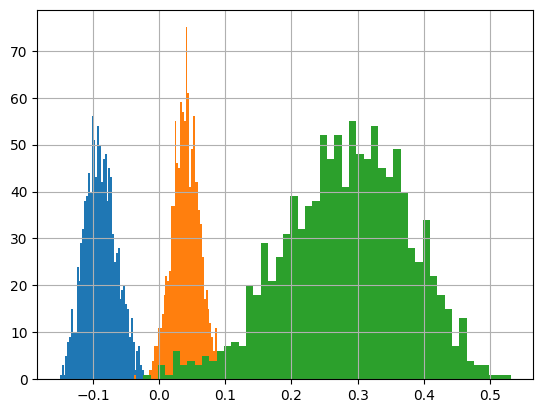

In [13]:
means_df['0.00'].hist(bins=50)
means_df['0.25'].hist(bins=50)
means_df['0.50'].hist(bins=50)

### Explore the dependence of the mean distances

In [19]:
means_df.corr()

,0.00,0.25,0.50
0.00,1.000000,-0.648163,-0.728125
0.25,-0.648163,1.000000,-0.049615
0.50,-0.728125,-0.049615,1.000000


In [24]:
means_df.mean()

0.00   -0.088183
0.25    0.040314
0.50    0.282747
dtype: float64

<Axes: >

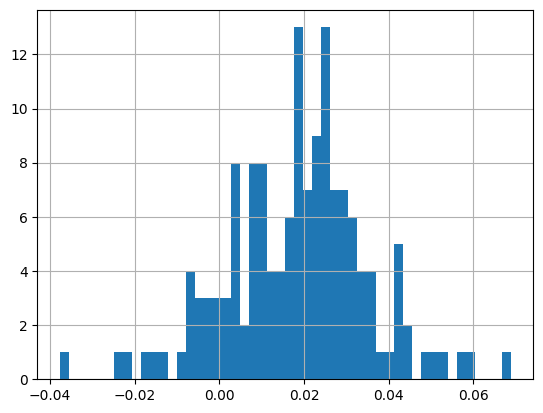

In [30]:
means_df.loc[(means_df['0.00'] > -0.06), '0.25'].hist(bins=50)

In [31]:
means_df['0_to_25'] = means_df['0.25'] - means_df['0.00']
means_df['25_to_50'] = means_df['0.50'] - means_df['0.25']

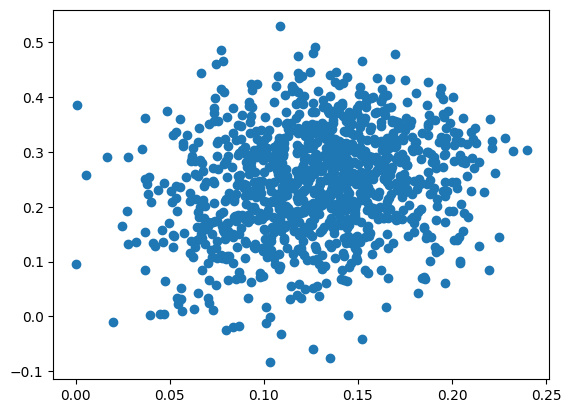

In [36]:
plt.plot(means_df['0_to_25'], means_df['25_to_50'], 'o')

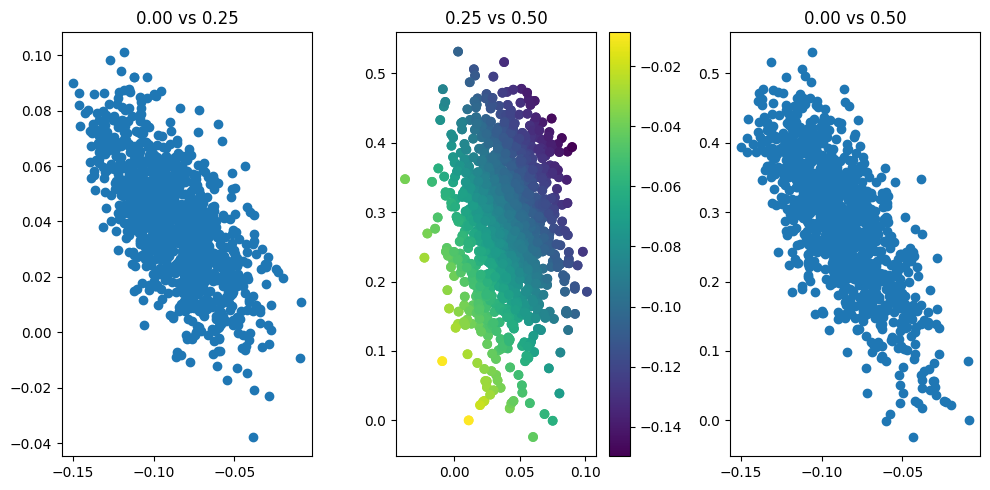

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].scatter(means_df['0.00'], means_df['0.25'])
ax[0].set_title('0.00 vs 0.25')
ax[1].scatter(means_df['0.25'], means_df['0.50'], c=means_df['0.00'].values, cmap='viridis')
ax[1].set_title('0.25 vs 0.50')
plt.colorbar(ax[1].scatter(means_df['0.25'], means_df['0.50'], c=means_df['0.00'].values, cmap='viridis'))
ax[2].scatter(means_df['0.00'], means_df['0.50'])
ax[2].set_title('0.00 vs 0.50')

plt.tight_layout()

In [60]:
# Find proportions of target values in train set
train['target'].value_counts(normalize=True)

target
0.50    0.499934
0.25    0.200789
0.75    0.200584
1.00    0.049411
0.00    0.049282
Name: proportion, dtype: float64

0.00 - 50% of time
0.25 - 40% of time
0.50 - 10% of time

<Axes: >

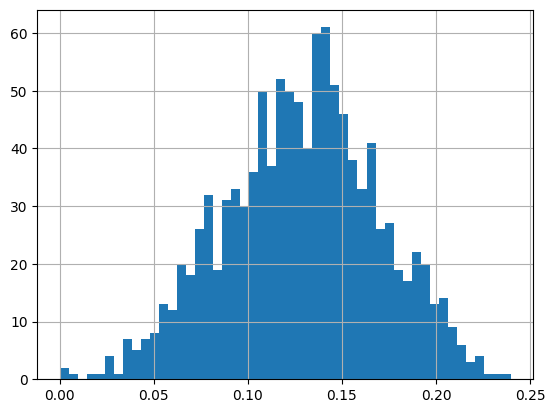

In [65]:
means_df["0_to_25"].hist(bins=50)

# Plot in 3d

In [21]:
means_df = pd.read_csv('../results/mean_distance.csv', index_col=0)

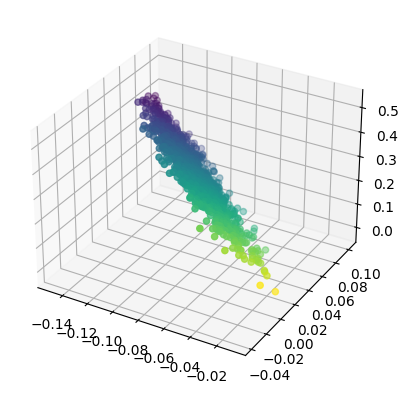

In [22]:
# Plot the 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(means_df['0.00'], means_df['0.25'], means_df['0.50'], c=means_df['0.00'], cmap='viridis')

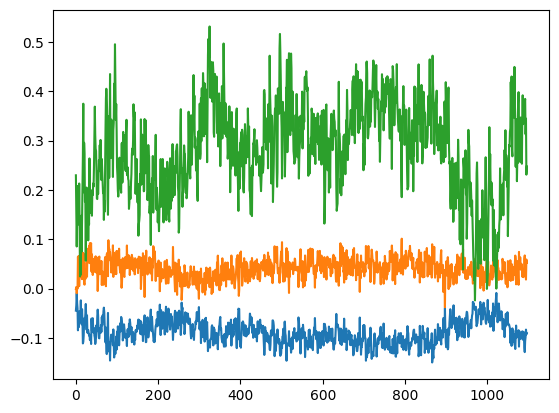

In [23]:
plt.plot(means_df['0.00'])
plt.plot(means_df['0.25'])
plt.plot(means_df['0.50'])

In [24]:
# Calculate covariance matrix
cov_matrix = np.cov(means_df.T)

means = means_df.mean().values

def joint_probability(x, means, cov_matrix):
    return (1 / (np.sqrt((2 * np.pi)**3 * np.linalg.det(cov_matrix))) * 
            np.exp(-0.5 * (x - means).T @ np.linalg.inv(cov_matrix) @ (x - means)))

joint_probability(means, means, cov_matrix)

64706.54810482494

In [25]:
train

,era,feature_aaronic_unexampled_arguer,feature_abactinal_inventable_luminescence,feature_abating_unadaptable_weakfish,feature_abdominal_subtriplicate_fin,feature_abducent_unbeneficed_lithophyte,feature_abducted_euphonic_pipewort,feature_ablest_mauritanian_elding,feature_abreast_viscoelastic_commander,feature_abrogative_hurt_lenition,...,feature_yokelish_metapsychological_lunt,feature_yorkist_authenticated_lotted,feature_yoruban_purplish_directoire,feature_yoruban_unapplied_tawse,feature_zincky_unseemly_butt,feature_zincoid_peccant_greywacke,feature_zoophoric_underglaze_algin,feature_zygodactyl_exponible_lathi,feature_zymotic_roundabout_figuration,target
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,2,2,0,2,3,2,4,2,2,...,2,2,2,2,2,2,2,3,2,0.25
n003bee128c2fcfc,0001,3,2,4,2,1,2,2,2,2,...,2,2,2,2,2,2,2,1,2,0.75
n0048ac83aff7194,0001,3,2,4,2,2,2,4,4,2,...,2,2,2,2,2,2,2,2,2,0.25
n00691bec80d3e02,0001,1,2,1,2,2,2,4,2,2,...,2,2,2,2,2,2,2,2,2,0.75
n00b8720a2fdc4f2,0001,1,2,0,2,1,2,2,3,2,...,2,2,2,2,2,2,2,1,2,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffc2d5e4b79a7ae,0573,3,4,4,3,2,1,2,3,0,...,4,4,4,1,1,3,2,1,4,0.25
nffc7d24176548a4,0573,4,2,0,2,2,0,3,4,3,...,2,2,2,2,2,4,2,3,2,0.50
nffc9844c1c7a6a9,0573,3,0,4,0,3,2,1,3,4,...,2,1,2,1,0,3,2,2,2,0.50


In [25]:
# Train model on one era
import lightgbm as lgb
model = lgb.LGBMRegressor(
    n_estimators=2000,  # If you want to use a larger model we've found 20_000 trees to be better
    learning_rate=0.01, # and a learning rate of 0.001
    max_depth=5, # and max_depth=6
    num_leaves=2**5-1, # and num_leaves of 2**6-1
    colsample_bytree=0.1
)
model.fit(
    train[train['era']=='0009'][features],
    train[train['era']=='0009']["target"]
)
# Define predict function
def predict(
    live_features: pd.DataFrame,
    live_benchmark_models: pd.DataFrame
 ) -> pd.DataFrame:
    live_predictions = model.predict(live_features[features])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6650
[LightGBM] [Info] Number of data points in the train set: 2370, number of used features: 1330
[LightGBM] [Info] Start training from score 0.499895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [26]:
import sys
import os

# Get the path to the previous directory
previous_directory = os.path.dirname(os.getcwd())

# Add the previous directory to the system path
sys.path.insert(0, previous_directory)

from auxiliary import utils

correlations = []
likelihoods = []

# Get all the models
models = [f for f in os.listdir("../models/ensemble") if f.endswith(".pkl")]
predicts = []
for model in models:
    with open(f"../models/ensemble/{model}", "rb") as f:
        predict = cloudpickle.load(f)
        predicts.append(predict)

for era in validation['era'].unique():
    predictions = []
    for predict in predicts:
        predictions.append(predict(validation[validation['era'] == era]))
    predictions = pd.concat(predictions, axis=1)
    predictions.columns = [f"model_{i}" for i in range(len(predictions.columns))]

    era_data = validation[validation['era'] == era].copy()

    era_data[features] = era_data[features] - era_data[features].mean()
    era_data['target'] = era_data['target'] - era_data['target'].mean().round(2)

    distance = np.sqrt((era_data[features]**2).sum(axis=1))
    era_data = pd.concat([era_data, pd.Series(distance, name='distance')], axis=1)

    # Normalize the distance
    era_data['distance'] = (era_data['distance'] - era_data['distance'].mean()) / era_data['distance'].std()

    for i, model in enumerate(predictions.columns):
        current_model = pd.concat(era_data, predictions[model])
        
        prediction_differences = np.abs(current_model[model] - current_model[model].mean())
        current_model = pd.concat([current_model, pd.Series(prediction_differences, name='pred_dif')], axis=1)


    prediction_differences = np.abs(era_data['prediction'] - era_data['prediction'].mean())
    era_data = pd.concat([era_data, pd.Series(prediction_differences, name='pred_dif')], axis=1)

    era_data = era_data.sort_values('pred_dif')

    n = len(era_data)
    indices_50_percent = n // 2
    indices_90_percent = indices_50_percent + 4 * n // 10

    era_data = era_data.reset_index(drop=True)  # Reset the index to get row numbers
    era_data['label'] = np.where(era_data.index < indices_50_percent, 0, np.where(era_data.index < indices_90_percent, 1, 2))

    likelihoods.append(joint_probability(era_data.groupby('label')['distance'].mean().values, means, cov_matrix))
    correlations.append(utils.numerai_corr(era_data['prediction'], era_data['target']))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

AttributeError: 'float' object has no attribute 'round'

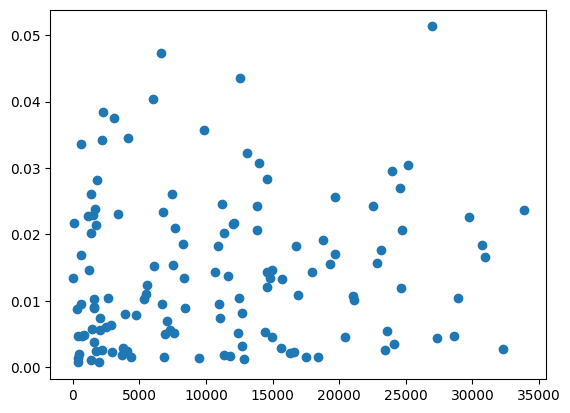

In [27]:
plt.plot(likelihoods, np.abs(correlations), 'o')

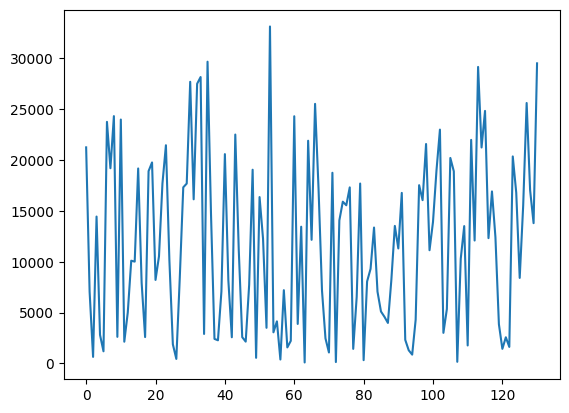

In [23]:
plt.plot(likelihoods)

# Distance of a point from other points

### Minimal distance of a point to another point

In [46]:
era_data = train[train['era'] == '0009'].copy()

era_data[features] = era_data[features] - era_data[features].mean()
era_data['target'] = era_data['target'] - era_data['target'].mean().round(2)

# Compute distances from first point to all other points
values = np.array(era_data[features].values)

min_distances = []
nn_distances = []

for i in range(0, len(values)):
    curr_val = values - values[i]
    curr_val = np.delete(curr_val, i, axis=0)
    distances = np.linalg.norm(curr_val, axis=1)
    distances = np.sort(distances)

    min_distances.append(distances.min())
    nn_distances.append(np.mean(distances[:30]))


In [48]:
era_data['min_distance'] = min_distances
era_data['nn_distance'] = nn_distances

C:\Users\Viktor\AppData\Local\Temp\ipykernel_30344\2253810265.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  era_data['min_distance'] = min_distances
C:\Users\Viktor\AppData\Local\Temp\ipykernel_30344\2253810265.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  era_data['nn_distance'] = nn_distances


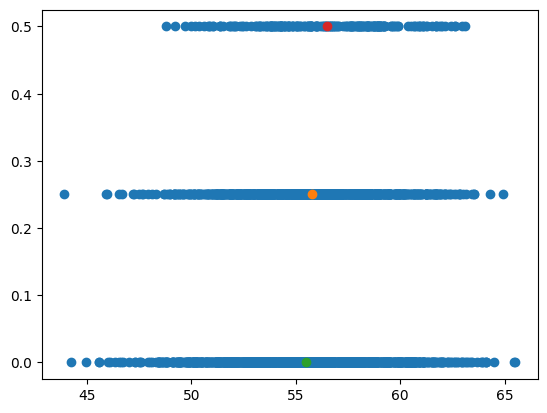

In [49]:
plt.plot(nn_distances, era_data['target'].abs(), 'o')

# Plot mean nn_distance for each target value
for target in era_data['target'].abs().unique():
    plt.plot(era_data[era_data['target'].abs() == target]['nn_distance'].mean(), target, 'o')

# Train model on every single training era

In [51]:
train = pd.read_parquet(f"../{DATA_VERSION}/train_int8.parquet", columns=["era"]+features+["target"])

In [ ]:
for era in train["era"].unique():
    model = lgb.LGBMRegressor(
        n_estimators=2000,  # If you want to use a larger model we've found 20_000 trees to be better
        learning_rate=0.01, # and a learning rate of 0.001
        max_depth=5, # and max_depth=6
        num_leaves=2**5-1, # and num_leaves of 2**6-1
        colsample_bytree=0.1
    )
    model.fit(
        train[train['era']==era][features],
        train[train['era']==era]["target"]
    )
    # Define predict function
    def predict(
        live_features: pd.DataFrame,
        live_benchmark_models: pd.DataFrame
    ) -> pd.DataFrame:
        live_predictions = model.predict(live_features[features])
        submission = pd.Series(live_predictions, index=live_features.index)
        return submission.to_frame("prediction")
    
    # Save to .pkl file
    with open(f"../models/ensemble/{era}.pkl", "wb") as f:
        cloudpickle.dump(predict, f)

In [16]:
# Make ensemble predictions
import os

# Get all the models
models = [f for f in os.listdir("../models/ensemble") if f.endswith(".pkl")]
predicts = []
for model in models:
    with open(f"../models/ensemble/{model}", "rb") as f:
        predict = cloudpickle.load(f)
        predicts.append(predict)

def ensemble_predict(live_features: pd.DataFrame, live_benchmark_models: pd.DataFrame) -> pd.DataFrame:
    predictions = []
    for predict in predicts:
        predictions.append(predict(live_features, live_benchmark_models))

    live_predictions = pd.concat(predictions, axis=1).mean(axis=1)

    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

In [19]:
import cloudpickle

# Save to .pkl file
with open(f"../models/ensemble.pkl", "wb") as f:
    cloudpickle.dump(ensemble_predict, f)

In [17]:
live_features = pd.read_parquet(f"../{DATA_VERSION}/live_int8.parquet", columns=["era"]+features)

ensemble_predictions = ensemble_predict(live_features, None)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [18]:
ensemble_predictions

,prediction
id,
n000e84c8d3d11e5,0.500391
n001bc8daadfb632,0.506981
n0024bc4321ff87d,0.508059
n002f40e114ef0d7,0.493215
n0081a84813aff33,0.494497
...,...
nff93e1dd2d427ed,0.500767
nffa6ef2ab1565f7,0.489037
nffac61194598f76,0.488363
